# Differentiation operators, matrices and their functions

In this notebook we will learn how to

* differentiate using differentiation operators (`diffop`) and differentiation matrices (`diffmatrix` and `expsolve.linalg.matmul`), 
* compute functions (including exponential) of differential operators (`diffopexp`),
* and of differential matrices (`torch.matrix_exp`),
* work with symbols in 1D (`fouriersymbol`, `fourierproduct`, `fourierfn`),
* and in higher dimensions (`tensorizesymbol`, `laplaciansymbol`, `laplacianop`, `laplacianopexp`).

[Back to tensorgrid quick introduction](00_quick_introduction.ipynb). 

*&#169; Copyright 2019-2023 Pranav Singh*

Use of this source code is governed by the MIT license that can be found in the LICENSE file.

In [1]:
import time

import numpy as np

import matplotlib.pyplot as plt

import expsolve as es
import expsolve.discretize.tensorgrid as ex

import torch
from torch import exp, sin, cos, abs, real, imag, pi, max, diag, float32, eye, kron
from torch.linalg import norm, matrix_exp

error = lambda u, uref : max(abs(u.flatten()-uref.flatten()))

## Differentiation operators - 1D

All spatial discretizations implement differentiation operator `diffop`. The default behaviour of `diffop` in `tensorgrid` spatial discretization is to use Fourier spectral differentiation, which utilises Fast Fourier Transform (FFT) for differentiation. 

The syntax for differentiation of a function in 1D is:

```Python
    df = ex.diffop(0, 1, f, xrange)
    d2f = ex.diffop(0, 2, f, xrange)
```

Here `f` is a vector with values of a function $f$ on a grid. Then `df` is the `1`st derivative of $f$ in the `0`th direction (i.e. the first and only coordinate). We also have to specify the (optional) `xrange` of the grid on which $f$ is discretized - the defaul value is `[-1,1]` as usual across all functions in `expsolve.discretize.tensorgrid`. The $k$ th derivative is obtained as `ex.diffop(0, k, f, xrange)`. Later in this notebook we will also see how to differentiate a `2d` function in either direction ($x$ or $y$).


**NOTE:**

* The floating point precision used for internal operations (e.g. FFT) depends on the the precision of `f`. However, since FFTs are only available for `float32` and higher accuracies in PyTorch, by default `diffop` will fail for `float16` data (i.e. half precision).

* If `f` is real-valued, the derivatives `df` and `d2f` are also guaranteed to be real-valued. This is beneficial when working with real-valued PDEs.

* `f` needs to be periodic on `xrange`. If it is not, spurious oscillations should be expected. 

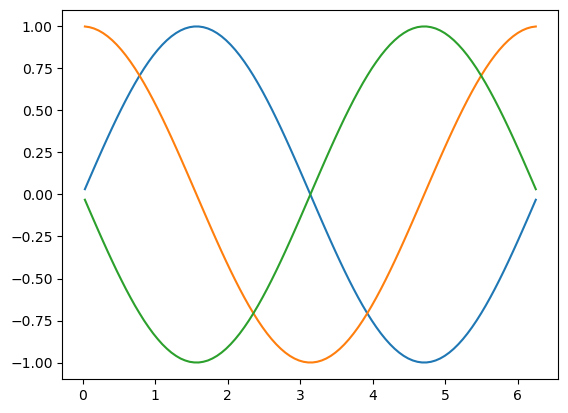

In [2]:
xrange = [0, 2*pi]
n = 100
x = ex.grid1d(n, xrange, dtype=float32)

s = sin(x)
ds = real(ex.diffop(0,1,s,xrange))      # 1st derivative of sin
d2s = real(ex.diffop(0,2,s,xrange))     # 2nd derivative of sin

ex.plot(plt, x, s)
ex.plot(plt, x, ds)
ex.plot(plt, x, d2s)
plt.show()

We can see that the derivative `ds` is `torch.float32`, which is consistent with accuracy of the grid `x` (and hence the function `s`), and it is real-valued.

In [3]:
print(ds)
print(ds.dtype)

tensor([[ 0.9995,  0.9956,  0.9877,  0.9759,  0.9603,  0.9409,  0.9178,  0.8910,
          0.8607,  0.8271,  0.7902,  0.7501,  0.7071,  0.6613,  0.6129,  0.5621,
          0.5090,  0.4540,  0.3971,  0.3387,  0.2790,  0.2181,  0.1564,  0.0941,
          0.0314, -0.0314, -0.0941, -0.1564, -0.2181, -0.2790, -0.3387, -0.3971,
         -0.4540, -0.5090, -0.5621, -0.6129, -0.6613, -0.7071, -0.7501, -0.7902,
         -0.8271, -0.8607, -0.8910, -0.9178, -0.9409, -0.9603, -0.9759, -0.9877,
         -0.9956, -0.9995, -0.9995, -0.9956, -0.9877, -0.9759, -0.9603, -0.9409,
         -0.9178, -0.8910, -0.8607, -0.8271, -0.7902, -0.7501, -0.7071, -0.6613,
         -0.6129, -0.5621, -0.5090, -0.4540, -0.3971, -0.3387, -0.2790, -0.2181,
         -0.1564, -0.0941, -0.0314,  0.0314,  0.0941,  0.1564,  0.2181,  0.2790,
          0.3387,  0.3971,  0.4540,  0.5090,  0.5621,  0.6129,  0.6613,  0.7071,
          0.7501,  0.7902,  0.8271,  0.8607,  0.8910,  0.9178,  0.9409,  0.9603,
          0.9759,  0.9877,  

Let's see how accurate the derivative computed in this way is. The true derivative of $\sin(x)$ is $\cos(x)$. 

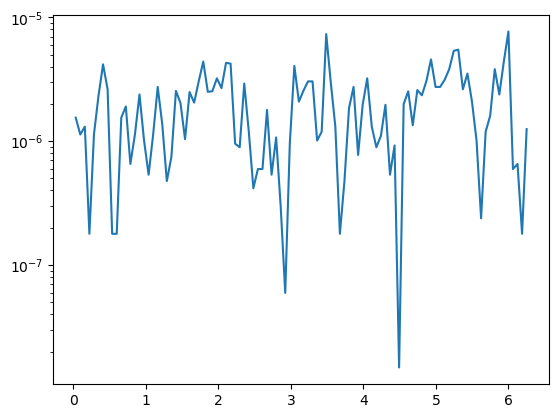

In [4]:
c = cos(x)
ex.semilogy(plt, x, abs(c-ds))
plt.show()

We can see that the derivative has $10^{-5}$ accuracy. In typical scientific applications, this is expected to be inadequate. The default choice of `float64` for the grid fixes this issue.

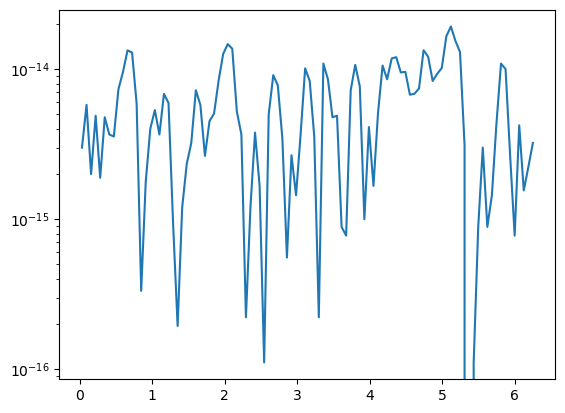

In [5]:
x = ex.grid1d(n, xrange)                # using default precision of `float64`
s = sin(x)
ds = real(ex.diffop(0,1,s,xrange))      # 1st derivative of sin
d2s = real(ex.diffop(0,2,s,xrange))     # 2nd derivative of sin

c = cos(x)
ex.semilogy(plt, x, abs(c-ds))
plt.show()

This shows us that the derivative computed in this way is extremely accurate. $\sin$ is a very simple function, of course. 

A more complicated example of a **periodic** function is $\exp(\sin(x))$ whose derivative is $\cos(x) \exp(\sin(x))$.

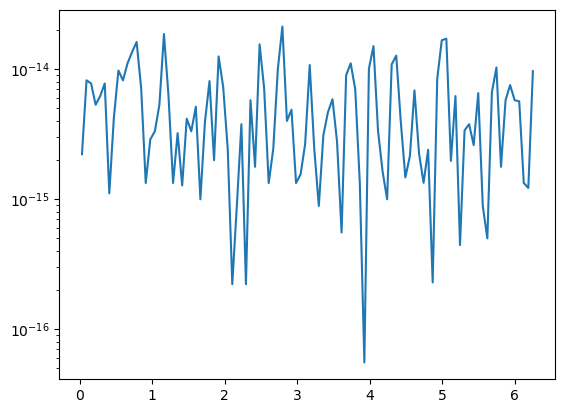

In [6]:
f = exp(sin(x))
df_true = cos(x)*exp(sin(x))
df_numerical = real(ex.diffop(0,1,f,xrange))

plt.semilogy(x.flatten(), abs(df_true-df_numerical).flatten())
plt.show()

Again, the computation looks accurate up to $14$ digits of precision!

#### Issues with non-periodicity

Differentiation in `tensorgrid` is ONLY accurate for smooth periodic functions! Let's see with an example:

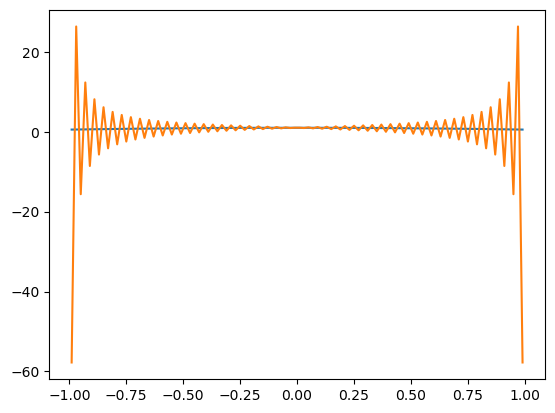

In [7]:
x = ex.grid1d(100)

s = sin(x)
ds_true = cos(x)
ds_numerical = real(ex.diffop(0, 1, s))

ex.plot(plt, x, ds_true)
ex.plot(plt, x, ds_numerical)
plt.show()

The computed derivative is extremely inaccurate since $sin$ is not periodic over $[-1,1]$ (note that we didn't specify `xrange` here, and so it defaults to `[-1,1]`).

Let's contrast this with a function that's periodic on $[-1,1]$:

In [8]:
s = sin(pi*x)
ds_true = pi*cos(pi*x)
ds_numerical = real(ex.diffop(0, 1, spi))

plt.figure(figsize=(8, 6), dpi=80)
ex.plot(plt, x, ds_true)
ex.plot(plt, x, ds_numerical, marker='.', linestyle=' ')
plt.show()

NameError: name 'spi' is not defined

## Differentiation operators - 2D

We consider the 2D function

$$ f= \sin(x+2y) + \exp(\sin(y)) \cos(y)$$

which is periodic over the grid $[0, 2 \pi]^2$ and whose (first) partial derivatives with respect to $x$ and $y$ are

$$\frac{\partial f}{\partial x} = \cos(x+2y) - \exp(\sin(y)) \sin(x)$$

and 

$$\frac{\partial f}{\partial y} = 2 \cos(x+2y) + \exp(\sin(y)) \cos(y) \cos(x), $$

which can be computed as

```Python
    dfx = ex.diffop(0, 1, f, xrange)
    dfy = ex.diffop(1, 1, f, xrange)
```

respectively. The second derivatives are:

$$\frac{\partial^2 f}{\partial x^2} = -\sin(x+2y) - \exp(\sin(y)) \cos(x)$$

and 

$$\frac{\partial^2 f}{\partial y^2} = -4 \sin(x+2y) + \exp(\sin(y)) \cos(y)^2 \cos(x) - \exp(\sin(y)) \sin(y) \cos(x), $$

which can be computed as 

```Python
    dfxx = ex.diffop(0, 2, f, xrange)
    dfyy = ex.diffop(1, 2, f, xrange)
```

while the mixed second derivative is

$$\frac{\partial^2 f}{\partial x \partial y} = -2 \sin(x+2y) - \exp(\sin(y)) \cos(y) \sin(x) $$


```Python
    dfxy = ex.diffop(1, 2, ex.diffop(0, 2, f, xrange), xrange)
```

Sometimes when `xrange` is fixed, the code *may* become more readable by defining `lambda` expressions for the differential operators. In the following example we will define 

* `Dx` for $\frac{\partial}{\partial x}$,
* `Dy` for $\frac{\partial}{\partial y}$,
* `Dxx` for $\frac{\partial^2}{\partial x^2}$,
* `Dyy` for $\frac{\partial^2}{\partial y^2}$, and
* `Lap` for the Laplacian,

$$ \Delta = \frac{\partial^2}{\partial x^2} + \frac{\partial^2}{\partial y^2}.$$




In [ ]:
xrange = [0, 2*pi]

Dx = lambda f: ex.diffop(0, 1, f, xrange)
Dy = lambda f: ex.diffop(1, 1, f, xrange)
Dxx = lambda f: ex.diffop(0, 2, f, xrange)
Dyy = lambda f: ex.diffop(1, 2, f, xrange)
Lap = lambda f: Dxx(f) + Dyy(f)

Now we can differentiate a function simply by applying `Dx` and `Dy` appropriate number of times.

In [ ]:
n = 50
[x,y] = ex.grid([n,n], xrange)      # 2D grid

f = sin(x+2*y) + exp(sin(y))*cos(x)

dfx = Dx(f)
dfy = Dy(f)
dfxx = Dxx(f)
dfyy = Dyy(f)
dfxy = Dx(Dy(f))
Lf = Lap(f)

We visualize the mixed derivative and the Laplacian of `f` below

In [ ]:
plt.figure()
ex.imshow(plt, xrange, dfxy)
plt.show()

plt.figure()
ex.imshow(plt, xrange, Lf)
plt.show()

Let us assess the accuracy of the derivatives

In [ ]:
dfx_true = cos(x+2*y) - exp(sin(y))*sin(x)
dfy_true = 2*cos(x+2*y) + exp(sin(y))*cos(y)*cos(x)

dfxx_true = -sin(x+2*y) - exp(sin(y)) * cos(x)
dfyy_true = -4 * sin(x+2*y) + exp(sin(y)) * cos(y)**2 * cos(x) - exp(sin(y)) * sin(y) * cos(x)

dfxy_true = -2 * sin(x+2*y) - exp(sin(y)) * cos(y) * sin(x) 

print(error(dfx, dfx_true))
print(error(dfy, dfy_true))
print(error(dfxx, dfxx_true))
print(error(dfyy, dfyy_true))
print(error(dfxy, dfxy_true))

Of course, it is not essential to define the lambda expressions for `diffop` - this merely makes your code easier to read. 

There are two ways to compute $\frac{\partial^2 f}{\partial x^2}$: apply `Dxx` (as we have shown), or apply `Dx` twice. Both are expected to be equivalent up to machine precision for large $n$. However, the second approach is expected to be twice as expensive. We show the second approach below:

In [ ]:
dfxx_alternative = Dx(Dx(f))
print(error(dfxx_alternative, dfxx))

## Differentiation Matrix

The differentation operator `diffop` is a function that differentiates a function `u`. This is a linear differentiation operator $D(u)$ which is a linear transformation, i.e. $D( a u + b v) = a D(u) + b D(v)$. All linear transformations have a matrix representation, and thus we must have a *matrix* $\mathbf{D}$ such that 

$$ D(u) = \mathbf{D} u$$

The way the (Fourier) differentiation operator `diffop` (i.e. $D$) is implemented, it uses FFT and thus costs $\mathcal{O}\left(n \log n\right)$, which is much more efficient than creating and storing the $n \times n$ matrix $\mathbf{D}$ and computing the matrix-vector product $\mathbf{D} u$, which costs $\mathcal{O}\left(n^2 \right)$.

However, sometimes we might want access to differentiation matrices such as $\mathbf{D}$. `tensorgrid` provides the `diffmatrix` function with the following syntax for this purpose:

```Python
    D = ex.diffmatrix(1, n, xrange)
```

where `D` is the first differentiation matrix (i.e. for computing the first derivative), `n` is the size of the matrix ($n \times n$) and `xrange` is as before. 

To differentiate a function `f` discretised on a grid on `xrange` with `n` points, we need to compute the matrix-vector product $\mathbf{D} f$.
For computing matrix-vector products in `expsolve` you should always use the the `matmul` function in `expsolve.linalg`. We have imported `expsolve` as `es`, so we need to compute

```Python
    ds = es.linalg.matmul(D, f)
```

* As always, the default value of `xrange` is `[-1,1]`.
* For even derivatives, differentiation matrix is real-valued. For odd derivatives it is complex-valued.
* `expsolve.linalag.matmul` does useful pre and post-processing such as takes caring of converting `D` and `s` to complex if either is complex, and is broadcast compatible. 
* It is recommended that you **do not try to use the `@` matrix multiplication operator instead of `matmul`**.

Here is an example of computing the second derivative by multiplying with the second differentation matrix:

In [ ]:
xrange = [0, 2*pi]
n = 100
x = ex.grid1d(n, xrange)

f = exp(sin(x))
d2f_true = -sin(x)*exp(sin(x)) + (cos(x)**2)*exp(sin(x))

D2 = ex.diffmatrix(2, n, xrange)            

D2f = es.linalg.matmul(D2, f)                  # matrix vector product 

plt.figure(figsize=(8, 6), dpi=80)
ex.plot(plt, x, D2f)
ex.plot(plt, x, d2f_true, marker='.',linestyle=' ')
plt.legend(['2nd derivative with diffmatrix', 'analytic 2nd derivative'])
plt.show()

Let's see what the error in computing second derivative with the differentiation matrix is.

In [ ]:
print(max(abs(es.linalg.matmul(D2, f) - d2f_true.flatten())))

### Why prefer differential operators over differentiation matrices?

This is only relevant for the Fourier differentiation matrices, not finite difference. 

The Fourier differentiation matrices can be diagonalized with Fourier matrices $\mathcal{F}$:

$$ \mathbf{D}_k = \mathcal{F}^{-1} \texttt{diag}(s_k) \mathcal{F} $$
where $s_k$ is the symbol of $\mathbf{D}_k$ (in particular, the $j$ th component of $s_k$ is $(s_k)_j = (-i j \pi)^k$). You can create an $n \times n$ Fourier matrix $\mathcal{F}$ in `tensorgrid` as `ex.cfftmatrix(n)`, although we will not be doing so explicitly.



In `tensogrid`, the function `diffop` computes the action of $\mathbf{D}_k$ on vector `u` as 

$$ \mathbf{D}_k = \mathcal{F}^{-1} \texttt{diag}(s_k) \mathcal{F} u = \texttt{ifft}\left(s_k\ \texttt{fft}(u) \right) $$

While the first form - $\mathcal{F}^{-1} \texttt{diag}(s_k) \mathcal{F} u$ - requires $\mathcal{O}(n^2)$ operations, the second form - $\texttt{ifft}\left(s_k\ \texttt{fft}(u) \right)$ - only involves comuting the FFT and inverse FFT, and can be computed in $\mathcal{O}(n \log n)$ operations. This is why `diffop` is preexrred to `diffmatrix` followed by matrix-vector multiplication, which costs $\mathcal{O}(n^2)$ cost and storage.

### Differentiation matrices in higher dimensions

`tensorgrid` does not explicitly provide a way to create differentiation matrices in higher dimensions. Partly this is due to the inefficiencies of doing so, but also since it is simple enough to do if you require. To do so, you only need to `kron` with appropriate identity matrices. 

In the following example, we recall the function

$$ f= \sin(x+2y) + \exp(\sin(y)) \cos(y)$$

that we had encountered earlier in the 2D example for `diffop`. However, we now consider it on the spatial domain $[0, 2 \pi] \times [-\pi, \pi]$, and discretize it with `23` points in the `x` direction and `62` in the `y` direction. 

In [ ]:
xrange = np.array([[0, 2*pi],[-pi,pi]])
n = [23, 62]
[x, y] = ex.grid(n, xrange)

f = sin(x+2*y) + exp(sin(y))*cos(x)
ex.imshow(plt, xrange, f)
plt.show()

The differential operator $\frac{\partial^2}{\partial x^2}$ is represented by a matrix 

$$ \mathbf{D}_{xx} = \mathbf{D}_2 \otimes \mathbf{I} $$

where $\otimes$ is the tensorization operator `kron`. The dimensions of `D2` and `I` need to match the underlying spatial dimensions. That is, `D2` needs to match the spatial grid size in `x` direction and `I` needs to match the grid size in the `y` direction. In our example we have deliberately used different grid sizes in `x` and `y` directions. 

Consequently, we need two different copies of `D2` and `I` depending on whether they are acting on `x` or `y`. We call these `D2a`, `D2b` and `Ia`, `Ib` respectively. 

In [ ]:
Ia = eye(n[0])
Ib = eye(n[1])

D2a = ex.diffmatrix(2, n[0], xrange)
D2b = ex.diffmatrix(2, n[1], xrange)

We then create the differential matrices `Dxxm` and `Dyym` that correspond to second derivatives in direction `x` and `y` respectively, as well as the Laplacian matrix.

In [ ]:
Dxxm = kron(D2a, Ib)
Dyym = kron(Ia, D2b)
Lapm = Dxxm + Dyym

To compare these to `diffop`, we redefine `Dxx` and `Dyy` (this is important since `xrange` has changed).

In [ ]:
Dxx = lambda f: ex.diffop(0, 2, f, xrange)
Dyy = lambda f: ex.diffop(1, 2, f, xrange)
Lap = lambda f: Dxx(f) + Dyy(f)

In [ ]:
print(error( es.linalg.matmul(Dxxm, f) , Dxx(f) ))
print(error( es.linalg.matmul(Dyym, f) , Dyy(f) ))
print(error( es.linalg.matmul(Lapm, f) , Lap(f)))

The error is higher here since the grids are not fine enough. To see the effect, set `n = [100, 100]` at the beginning of this example.

## Functions of differential operators - 1D

We can easily see that 

$$ \left(\mathbf{D}_k\right)^n = \mathcal{F}^{-1} \texttt{diag}((s_k)^n) \mathcal{F} $$

For any analytic function $g$, 

$$ g(c \mathbf{D}_k) = \mathcal{F}^{-1} \texttt{diag}(g(c s_k)) \mathcal{F} $$

for any $c \in \mathbb{C}$, and it's action on a vector $u$ is computed in $\mathcal{O}(n \log n)$ operations as 

$$ g(c \mathbf{D}_k) u= \mathcal{F}^{-1} \texttt{diag}(g(c s_k)) \mathcal{F} u = \texttt{ifft}\left( g(c s_k) \texttt{fft}(u) \right) .$$

Since $g$ only acts on $c s_k$ which involved $\mathcal{O}(n)$ operations, the computation of $g(c \mathbf{D}_k) u$ is almost as expensive as a single computation of $\mathbf{D}_k$ using FFT: i.e. $\mathcal{O}(n \log n)$.

#### $\star$ `fouriersymbol` and `fourierproduct`



The first component that we need for computing arbitrary functions of differential operators is the symbol $s_k$. The 1D symbol of the first differential operator (i.e. $\mathbf{D}_1$) can be created in `tensorgrid` using

```Python
    sk = ex.fouriersymbol(n, xrange)
```

where `n` is the number of grid points and `xrange` is the spatial domain. We can then compute the first derivative as

```Python
    dfs = ex.fourierproduct(sk, f, 0)
```

the third derivative as

```Python
    d3fs = ex.fourierproduct(sk**3, f, 0)
```

Here the third parameter is the dimension in which the fourier symbol needs to be applied. In 1D case this is always 0.

In [ ]:
xrange = [0, 2*pi]
n = 100
x = ex.grid1d(n, xrange)

f = exp(sin(x))

df_true = cos(x)*exp(sin(x))
df = ex.diffop(0, 1, f, xrange)

d3f_true = -cos(x)*exp(sin(x)) + -sin(x)*cos(x)*exp(sin(x)) + (cos(x)**3)*exp(sin(x)) -2.*sin(x)*cos(x)*exp(sin(x)) 
d3f = ex.diffop(0, 3, f, xrange)

sk = ex.fouriersymbol(n, xrange)

dfs = real(ex.fourierproduct(sk, f, 0))
d3fs = real(ex.fourierproduct(sk**3, f, 0))

plt.figure(figsize=(8, 6), dpi=80)
ex.plot(plt, x, d3fs)
ex.plot(plt, x, d3f, marker='o',linestyle=' ')
ex.plot(plt, x, d3f_true, marker='.',linestyle=' ')
plt.legend(['3rd derivative using symbol', '3rd derivative using diffop', 'analytic 3rd derivative'])
plt.show()

Note that this implements the functionality already available in `diffop`. However, `diffop` also takes care of managing real and complex-valued inputs appropriately. Here we have had to explicitly take the real component of the `fourierproduct` output.

The relevance of the symbol way of doing things is that we can now compute arbitary functions of differential operators, e.g. we can compute $g(c\mathbf{D}_1) f$ as 
```Python
    dgfs = ex.fourierproduct(g(c * sk), f, 0)
```
where the last parameter is the dimension along which the fourier symbol needs to act. We demonstrate this with $g(s)=$

$$\quad \exp(s^2),  \quad \exp(s), \quad \sin(s^2), \quad \text{and} \quad \exp(i s^2 + 5 s), $$

which effectively compute the actions of 

$$ e^{\partial_x^2}, \quad e^{\partial_x}, \quad \sin\left(\partial_x^2\right), \quad \text{and} \quad e^{i \partial^2_x + 5 \partial_x}, $$

respectively.

In [ ]:
glist = [lambda s: exp(s**2), lambda s: exp(s), lambda s: sin(s**2), lambda s: exp(1j*s**2 + 5.*s)]

dgfs = [ex.fourierproduct(g(sk), f, d=0) for g in glist]

dgfs[0] = real(dgfs[0])
dgfs[1] = real(dgfs[1])
dgfs[2] = real(dgfs[2])

for dg in dgfs:
    ex.plot(plt, x, real(dg))   # showing only the real part of dgfs[3]
plt.show()

With the exception of the last operator, which results in complex-valued function, all other functions should be real-valued, so we extract the real component after computing the `fourierproduct`.





#### $\star$ `fourierfn`


The function `fourierfn` provides the same functionality as the combination of `fouriersymbol` and `fourierproduct`, and can be used for more compact code. We can simply call it as

```Python
    dgf = ex.fourierfn(g, f, 0, xrange)
```

In [ ]:
glist = [lambda s: exp(s**2), lambda s: exp(s), lambda s: sin(s**2), lambda s: exp(1j*s**2 + 5.*s)]

dgf = [ex.fourierfn(g, f, 0, xrange) for g in glist]

dgf[0] = real(dgf[0])
dgf[1] = real(dgf[1])
dgf[2] = real(dgf[2])

for dg in dgf:
    ex.plot(plt, x, real(dg))   # showing only the real part of dgf[3]
plt.show()

Internally, `fourierfn` creates a symbol $s_k$ for every application. So although it is more compact, the combination of `fouriersymbol` with `fourierproduct` is more efficient in general applications.

#### $\star$ `diffopexp`

A very commonly used function in the solution of differential equations is the exponential of a differential operator. This functionality is implemented in the function `diffopexp`, whose syntax is:


```Python
    eDkf = ex.diffopexp(0, k, c, f, xrange) 
```
which computes $\exp(c \partial^k_x) f$, where `f` is the dicretized function. The first component is always $0$ in 1D, indicating differentiation with respect to `x`.

In [ ]:
eD2f = ex.diffopexp(0, 2, 1., f, xrange) 
eD1f = ex.diffopexp(0, 1, 1., f, xrange) 

ex.plot(plt, x, eD2f)
ex.plot(plt, x, eD1f)
plt.show()

We have already computed these using `fourierfn` (as well as `fouriersymbol` and `fourierproduct` approach). We can check that these approaches lead to the same solution.

In [ ]:
print(error(eD2f, dgf[0]))
print(error(eD1f, dgf[1]))

* `diffopexp` takes care of real and complex-valued inputs appropriately (unlike `fourierfn` and `fourierproduct` etc), and we didn't have to typecast to `real`.
* `diffopexp` is as efficient as `fourierfn` (and utilizes this internally), and is therefore less efficient than the combination of `fouriersymbol` and `fourierproduct` for multiple runs.

## Functions of differential operators - higher dimensions, one dimension at a time

For higher dimensions, `diffopexp` computes the exponential of an operator acting in a specific dimension `j`:

```Python
    eDjkf = ex.diffopexp(j, k, c, f, xrange) 
```
to compute $ e^{c \partial_{x_j}^k} f$. For instance, we compute $ e^{0.1 \partial_{y}^2} f$ and $ e^{3 \partial_{x}^3} f$ in the following code.

In [ ]:
xrange = np.array([[0, 2*pi], [-pi, pi]])
n = [88, 103]
[x, y] = ex.grid(n, xrange)      # 2D grid

f = sin(8.*x+4.*y) + exp(sin(2.*y))*cos(6.*x)

eDy2f = ex.diffopexp(1, 2, 0.1, f, xrange) 
eDx3f = ex.diffopexp(0, 3, 3, f, xrange) 

plt.figure()
ex.imshow(plt, xrange, f)
plt.show()

plt.figure()
ex.imshow(plt, xrange, eDy2f)
plt.show()

plt.figure()
ex.imshow(plt, xrange, eDx3f)
plt.show()

As before, the same can be achieved by using `fouriersymbol` and `fourierproduct`. However, care has to be taken that `fouriersymbol` should only be created according to the specific dimension (i.e. direction) in which it needs to be applied: `n` should be the number of grid points in this direction and `xrange` should a list `[a,b]` which specifies the spatial extent in this direction. `fourierproduct` should then be applied as

```Python
    dgfs = ex.fourierproduct(g(c * sk), f, j)
```

As before, the equivalent of `diffopexp` is obtained by setting `g=exp`.

In [ ]:
sx = ex.fouriersymbol(n[0], xrange[0])    
sy = ex.fouriersymbol(n[1], xrange[1])    

eDy2fs = real(ex.fourierproduct(exp(0.1*sy**2), f, 1)) 
eDx3fs = real(ex.fourierproduct(exp(3*sx**3), f, 0)) 

print(error(eDy2fs, eDy2f))
print(error(eDx3fs, eDx3f))

We can see that the two methods are equivalent. As before, the `fouriersymbol` approach is more efficient since the symbol does not have to be computed multiple times. However, in higher dimensions this advantage is less pronounced when each differential operator is restricted to working in 1 dimension only. We will later see how to create higher dimensional symbols, where this advantage is restored.

Once again, unlike `diffopexp` which returns real-valued solutions where appropriate, we have to cast the output manually in the case of `fouriersymbol` and `fourierproduct` approach.

## Functions of differential operators - higher dimensions, all at once

The previous approach applies `fft` in the `j`th dimension only: i.e. the direction in which the differential operator $\partial_{x_j}^k$ acts. However, this may be inefficient. For instance, when we want to compute the action of the Laplacian, $\Delta$, or its functions (e.g. the exponential of Laplacian), it is more efficient to act on all directions at once - i.e. use `fftn` which transforms all direction, and use an n-dimensional symbol. 

#### $\star$ `tensorizesymbol`

We can create tensorized `x` and `y` symbols `Sx` and `Sy` using `tensorizesymbol` as

```Python
    [Sx, Sy] = ex.tensorizesymbol(symbolfn, n, xrange)
```

In general this can be done for arbitary dimensions. The `symbolfn` should be `ex.fouriersymbol` (unless you are using finite differences, or you know what you are doing). 

In [ ]:
[Sx, Sy] = ex.tensorizesymbol(ex.fouriersymbol, n, xrange)
print(Sx.shape)
print(sx.shape)

print(Sy.shape)
print(sy.shape)

Note that the shape of the symbol `Sx` is `1 x nx x ny` unlike the symbol `sx` which has the shape `nx`.

We can then apply any function `g` of the symbols `Sx` and `Sy` using `fourierproduct` as

```Python
    dgfs = ex.fourierproduct(g(Sx, Sy), f)
```

For example,

* `g(Sx, Sy) = Sx + Sy` implements $\partial_x f + \partial_y f$
* `g(Sx, Sy) = Sx * Sy` implements $\partial_x \partial_y f$
* `g(Sx, Sy) = exp(Sx + 10.*Sy + 0.1*Sx**2)` implements $e^{\partial_x + 10 \partial_y + 0.1 \partial_x^2} f$

We check this against alternative ways of computing the same operators:

In [ ]:
dxpyfs = real(ex.fourierproduct(Sx + Sy, f))
dxpyf = ex.diffop(0, 1, f, xrange) + ex.diffop(1, 1, f, xrange)

dxyfs = real(ex.fourierproduct(Sx * Sy, f))
dxyf = ex.diffop(0, 1, ex.diffop(1, 1, f, xrange), xrange)

expdxpyfs = real(ex.fourierproduct(exp(Sx + 10.*Sy + 0.1*Sx**2), f))
expdxpyf = ex.diffopexp(0, 2, 0.1, ex.diffopexp(0, 1, 1., ex.diffopexp(1, 1, 10., f, xrange), xrange), xrange)

print(error(dxpyfs, dxpyf))
print(error(dxyfs, dxyf))
print(error(expdxpyfs, expdxpyf))

In [ ]:
ex.imshow(plt, xrange, expdxpyfs)

The same can be achieved with `fourierfn`

In [ ]:
dxpyfs2 = ex.fourierfn(lambda S: S[0] + S[1], f, d=-1, xrange=xrange)
print(error(dxpyfs2, dxpyfs))

Note:

* Since `fourierfn` creates the symbol internally each time, it is less efficient to use in general.
* You must pass `d=-1`, which is the way of specifying that the function acts on *all dimensions*. 
* Correspondingly, the function sent as the first parameter to `fourierfn` should take 2 inputs in 2D. 

#### $\star$ `laplaciansymbol`, `laplacianop` and  `laplacianopexp`

Due to the frequency with which the functions of Laplacian appear in practice, we have special functions just for the computation of its symbol and its functions.

The syntax for creating the symbol of the Laplacian follows that for `tensorizesymbol`:

```Python
    SL = ex.laplaciansymbol(symbolfn, n, xrange)
```

As before, the `symbolfn` should be `ex.fouriersymbol` (unless you are using finite differences, or you know what you are doing). 

A difference now is that `SL` is no longer a list of `x` and `y` symbols, `Sx` and `Sy`. Instead it is the special function of these `SL = Sx**2 + Sy**2` (in higher dimensions, this generalizes to be a sum of the square of all individual direction symbols). This makes it possible to combine it with `fourierproduct` function immediately to compute the action of the Laplacian and its functions.

In the following example we show how to compute $\Delta f$ and $e^{0.1 \Delta} f$ using `laplaciansymbol`. The result is the same as using `diffop` and `diffopexp` appropriately.

In [ ]:
SL = ex.laplaciansymbol(ex.fouriersymbol, n, xrange)

print(error(SL, Sx**2 + Sy**2))

Lf = real(ex.fourierproduct(SL, f))
expLf = real(ex.fourierproduct(exp(0.1 * SL), f))

Lf2 = ex.diffop(0, 2, f, xrange) + ex.diffop(1, 2, f, xrange)
expLf2 = ex.diffopexp(0, 2, 0.1, ex.diffopexp(1, 2, 0.1, f, xrange) , xrange) 

print(error(Lf, Lf2))
print(error(expLf, expLf2))

The `laplacianop` function provides a light wrapper around the above functionality. It is called as:

```Python
    Lf = ex.laplacianop(lapsymb, f)
```
and computes the action of the Laplacian on `f`. The only difference from `fourierproduct` is that `laplacianop` takes care of real and complex-valued inputs correctly.

`laplacianopexp` provides a similarly light wrapper for computation of Laplacian exponential. It is called as

```Python
    expLf = ex.laplacianopexp(lapsymb, s, u):
```
for the computation of $e^{s \Delta} f$ for a scalar $s$.


In [ ]:
Lf3 = ex.laplacianop(SL, f)
expLf3 = ex.laplacianopexp(SL, 0.1, f)

print(error(Lf, Lf2))
print(error(expLf, expLf2))

## Exponentials of differential matrices

We can also compute the exponential of the differentiation matrix directly using `torch`'s `matrix_exp` function. As before, the matrix-vector product should be computed using `expsolve.linalg.matmul`, not `@`. 

We test this against `diffopexp` for 1D.

In [ ]:
xrange = [0, 2*pi]
n = 100

x = ex.grid1d(n, xrange)
f = exp(sin(x))

D2 = ex.diffmatrix(2, n, xrange)            
expD2 = matrix_exp(0.1*D2)
expD2f = es.linalg.matmul(expD2, f)

expd2f = ex.diffopexp(0, 2, 0.1, f, xrange)

print(error(expD2f, expd2f))

We can do the same for higher dimensions. For simplicity, we consider the case where spatial domain is $[0, 2 \pi]^2$ and `nx=ny=50`.

In [ ]:
xrange = [0, 2*pi]
n = [50, 50]
I = eye(n[0])
D2 = ex.diffmatrix(2, n[0], xrange)            

Dxx = kron(D2, I)
Dyy = kron(I, D2)
Lap = Dxx + Dyy

x, y = ex.grid(n, xrange)
f = sin(x+2*y) + exp(sin(y))*cos(x)

tim1 = time.time()
expL = matrix_exp(0.1*Lap)
expLf = es.linalg.matmul(expL, f)
tim2 = time.time()
print(f'matrix_exp approach took {tim2-tim1}s')

tim1 = time.time()
SL = ex.laplaciansymbol(ex.fouriersymbol, n, xrange)
expLfS = ex.laplacianopexp(SL, 0.1, f)
tim2 = time.time()
print(f'fourier symbol approach took {tim2-tim1}s')

print(error(expLf, expLfS))